In [36]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats

import os, sys

util_path = os.path.abspath(os.path.join(os.path.pardir, "utilities_and_data"))
if util_path not in sys.path and os.path.exists(util_path):
    sys.path.insert(0, util_path)

import plot_tools

plt.rc("font", size=12)

### Bayesian Data Analysis, 3rd ed
##  Chapter 6, demo 3

This is based on BDA3 p. 146-147.

Posterior predictive checking for the light speed example (as from [demo 6.1](demo6_1.ipynb)) with a poorly chosen test statistic. The test quantity chosen is the sample variance which is modelled directly and so, given an uninformative prior, the posterior is centered at the observed value. 

### Load data

In [2]:
data_path = os.path.abspath(
    os.path.join(os.path.pardir, "utilities_and_data", "light.txt")
)
y = np.loadtxt(data_path)

n = len(y)
s2 = np.var(y, ddof=1)  # Here ddof=1 is used to get the sample estimate.
s = np.sqrt(s2)
my = np.mean(y)

In [3]:
rng = np.random.default_rng(42)

### Sample 

In [4]:
nsamp = 1000
pps = rng.standard_t(n - 1, size=(n, nsamp)) * np.sqrt(s2 * (1 + 1 / n)) + my
pp = np.var(pps, axis=0, ddof=1)

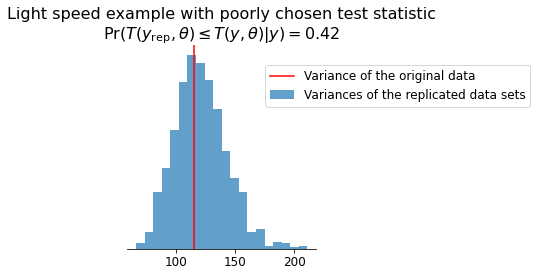

In [5]:
plt.hist(
    pp,
    20,
    label="Variances of the replicated data sets",
    color=plot_tools.lighten("C0", 0.3),
)
plt.axvline(s2, color="red", label="Variance of the original data")
plt.title(
    "Light speed example with poorly chosen test statistic\n"
    r"$\operatorname{Pr}(T(y_\mathrm{rep},\theta)\leq T(y,\theta)|y)=0.42$",
    fontsize=16,
)
plt.legend(loc="center left", bbox_to_anchor=(0.7, 0.8))
plot_tools.modify_axes.only_x(plt.gca())
plt.tight_layout()

### Marginal posterior of $\mu$

In [6]:
def print_quantiles(arr, q=[0.025, 0.25, 0.5, 0.75, 0.975], dp=1):
    q = np.quantile(arr, q=q)
    print(np.round(q, dp))

In [107]:
num_replicates = 2000

sigma2 = (n - 1) * s2 / rng.chisquare(n - 1, size=num_replicates)
mu_post = rng.normal(y.mean(), np.sqrt(sigma2 / n))

y_6 = sorted(y)[5]
y_61 = sorted(y)[60]

Ty = np.abs(y_61 - mu_post) - np.abs(y_6 - mu_post)

We can sample new data from the posterior predictive in two ways:

1. Sample $(\theta, \sigma^2)$ from their posterior, then sample $\tilde{y}$ from the normal likelihood.
2. Sample $\tilde{y}$ directly from its posterior predictive distribution (we know it in this case, it's a student-t).

However, given we want to compute a test quantity $T(y, \theta)$ that depends on both the data $y$ and the parameters, we need to keep track of which parameters generated each dataset and so only option 1 is valid.

**A note on notation**: in BDA3 Chapter 6 $\theta$ is referred to as the vector of all parameters and then, confusingly, on page 147 it's used to denote just the mean parameter.

In [110]:
replicates = rng.normal(
    mu_post[:, None], np.sqrt(sigma2[:, None]), size=(num_replicates, n)
)
replicates1 = (
    rng.standard_t(n - 1, size=(num_replicates, n)) * np.sqrt(s2 * (1 + 1 / n))
    + my
)

replicates_sorted = np.sort(replicates)
replicates_6 = replicates_sorted[:, 5]
replicates_61 = replicates_sorted[:, 60]
Tyr = np.abs(replicates_61 - mu_post) - np.abs(replicates_6 - mu_post)

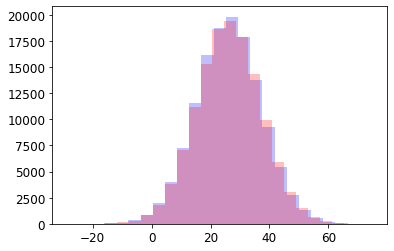

In [111]:
plt.hist(replicates.reshape(-1), bins=25, alpha=0.25, color="blue")
plt.hist(replicates1.reshape(-1), bins=25, alpha=0.25, color="red");

For some reason it's not possible to replicate Gelman's p-value of 0.28.

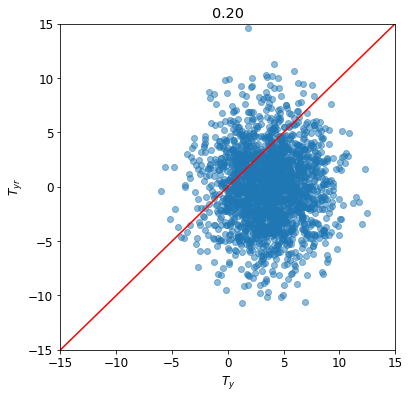

In [113]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(Ty, Tyr, alpha=0.5)
ax.set_xlim(-15, 15)
ax.set_ylim(-15, 15)
ax.plot([-15, 15], [-15, 15], color="red")
ax.set_xlabel("$T_y$")
ax.set_ylabel("$T_{yr}$")
plt.title(f"{np.mean(Tyr > Ty):.2f}");